# =====================================================
# LAB BERTOPIC - EXPERIMENTACIÓN INTERACTIVA
# =====================================================
# Notebook diseñado para experimentar con parámetros
# sin repetir procesos costosos como embeddings

# # 🚀 SETUP INICIAL (Ejecutar solo una vez)


In [1]:
# === INSTALAR DEPENDENCIAS (Solo primera vez) ===
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
!pip install bertopic umap-learn hdbscan

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 603, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 603 (delta 131), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (603/603), 199.38 KiB | 1.10 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Installing RAPIDS remaining 25.08 libraries
Using Python 3.12.11 environment at: /usr
Resolved 180 packages in 1.40s
Prepared 41 packages in 29.20s
Uninstalled 31 packages in 1.51s
Installed 41 packages in 145ms
 - bokeh==3.7.3
 + bokeh==3.6.3
 + cucim-cu12==25.8.0
 + cuda-bindings==12.9.2
 + cuda-pathfinder==1.2.3
 - cuda-python==12.6.2.post1
 + cuda-python==12.9.2
 - cudf-cu12==25.6.0 (from https://pypi.nvidia.com/cudf-cu12/cudf_cu12-25.6.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl)
 + cudf-cu12==25.8.0
 + cugraph-cu12==25.8.0
 - cuml-cu12==25.6.0
 + cuml-cu12==25.8.0
 - cuvs-cu12==25.6.1
 + cuvs-cu12==25.8.0
 + cu

# # 📁 1. CONFIGURACIÓN Y CARGA DE DATOS


In [2]:
import os
import sys
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import openai
import cupy as cp
from cuml.manifold import UMAP as cuUMAP
from cuml.cluster import HDBSCAN as cuHDBSCAN
from bertopic.representation import OpenAI
from bertopic import BERTopic
import re
import ast
import pickle
from datetime import datetime

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# === CONFIGURACIÓN GLOBAL ===
OPENAI_API_KEY = "sk-proj-3P2_..."  # ⚠️ CAMBIAR

# Rutas
MAIN_FOLDER = 'Machine Learning Projects'
PROJECT_FOLDER = 'Analisis Cluster Data Importacion'
DATA_PATH = './datos/data_para_etiquetar_no_supervisado.csv'
DICTIONARY_PATH = './datos/dicaranceles.xlsx'

# Parámetros de muestreo
SAMPLE_SIZE = 20
RANDOM_STATE = 42

# Rutas para guardar/cargar estados
EMBEDDINGS_PATH = './cache/embeddings_openai.npy'
PROCESSED_DATA_PATH = './cache/processed_data.pkl'
REDUCED_EMBEDDINGS_PATH = './cache/reduced_embeddings_{}.npy'

# %%
# === MONTAR DRIVE Y CONFIGURAR PROYECTO ===
drive.mount('/content/drive')
base_dir = f'/content/drive/MyDrive/{MAIN_FOLDER}/{PROJECT_FOLDER}'
os.chdir(base_dir)
sys.path.append(f'/content/drive/MyDrive/{MAIN_FOLDER}')

# Crear carpeta cache si no existe
os.makedirs('./cache', exist_ok=True)
os.makedirs('./tablas', exist_ok=True)

print(f"✅ Directorio de trabajo: {os.getcwd()}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Directorio de trabajo: /content/drive/MyDrive/Machine Learning Projects/Analisis Cluster Data Importacion


# # 🔄 2. CARGA Y PROCESAMIENTO DE DATOS (Ejecutar una vez)


In [21]:
# === IMPORTAR UTILIDADES DEL PROYECTO ===
from lab_utils import get_data, tariff_description, sugerencias_builder

# === FUNCIONES DE PROCESAMIENTO DE TEXTO ===
def corpus_cleaner(df, column_corpus="corpus", new_column="corpus_limpio"):
    """Limpia el corpus de texto"""
    palabras_a_eliminar = set([
        'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 'lo', 'al', 'del',
        'de', 'a', 'en', 'y', 'que', 'con', 'por', 'para', 'sin', 'sobre', 'bajo',
        'entre', 'hacia', 'hasta', 'desde', 'durante', 'se', 'su', 'sus', 'le', 'les',
        'me', 'te', 'nos', 'os', 'mi', 'tu', 'nuestro', 'vuestro', 'muy', 'mas', 'menos',
        'también', 'además', 'incluso', 'inclusive', 'siempre', 'nunca', 'ahora',
        'después', 'antes', 'aquí', 'allí', 'pniña', 'articulos', 'similares', 'partes',
        'punto', 'tipo', 'vez', 'cosas', 'hecho', 'caso', 'ejemplo', 'manera', 'forma',
        'fin', 'modo', 'demas', 'similar', 'otras', 'excepto', 'partida', 'incluidas',
        'incluidos', 'patrones', 'esta', 'clase', 'artic', 'partidas', 'aunque', 'esten',
        'en', 'parte', 'mm', 'set', 'transporte', 'ser', 'estar', 'tener', 'haber',
        'hacer', 'poder', 'decir', 'ver', 'saber'
    ])

    def clean_text(text):
        if pd.isna(text):
            return ""
        text = re.sub(r'[^\w\s]', '', text)
        regex_palabras = r'(?<!\w)(' + '|'.join(map(re.escape, palabras_a_eliminar)) + r')(?!\w)'
        text = re.sub(regex_palabras, '', text, flags=re.IGNORECASE)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    result = df.copy()
    result[new_column] = result[column_corpus].apply(clean_text)
    return result

# Keywords para vehículos
keywords_vehiculos = {
    "vehiculos", "vehículo", "vehículos", "automoviles", "automóvil", "automóviles",
    "carro", "carros", "auto", "autos", "camioneta", "camionetas", "camión", "camiones"
}

keywords_compuestas = [
    "repuesto para vehiculos", "repuesto para vehículo", "repuesto para carro",
    "repuesto para auto", "partes de carro", "partes de vehiculos"
]

def extract_texto_lectura(row):
    """Extrae texto optimizado para lectura"""
    # [Misma implementación que tenías]
    text2 = str(row["text2"])
    corpus_limpio = str(row["corpus_limpio"])

    # Primeras dos palabras
    palabras = corpus_limpio.split()
    parte1 = " ".join(palabras[:2])

    # Patrón manufacturas
    match = re.search(r"LAS DEMAS MANUFACTURAS DE ([^,Y\n]+)", text2, re.IGNORECASE)
    parte2 = ""
    if match:
        articulo = match.group(1).strip()
        palabras = [w for w in articulo.split() if w.lower() not in {'de', 'la', 'el', 'los', 'las'}]
        if palabras:
            parte2 = f"manufacturas de {' '.join(palabras)}"

    # Keywords
    parte3 = ""
    corpus_lower = corpus_limpio.lower()
    for kw in keywords_vehiculos:
        if kw in corpus_lower.split():
            parte3 += f" {kw}"

    resultado = f"{parte1} {parte2} {parte3}".strip()
    return resultado.lower()

# %%
# === CARGAR Y PROCESAR DATOS ===
# Verificar si ya existe el archivo procesado
if os.path.exists(PROCESSED_DATA_PATH):
    print("📂 Cargando datos procesados desde cache...")
    with open(PROCESSED_DATA_PATH, 'rb') as f:
        data_dict = pickle.load(f)
    df = data_dict['df']
    abstracts = data_dict['abstracts']
    print(f"✅ Datos cargados desde cache: {len(df)} registros")
else:
    print("🔄 Procesando datos por primera vez...")

    # Cargar datos
    df = get_data(DATA_PATH)
    df_diccionario = get_data(DICTIONARY_PATH)
    print(f"📊 Datos originales: {df.shape[0]} filas")

    # Muestrear
    df = df.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE).reset_index(drop=True)

    # Enriquecer
    df = tariff_description(df, df_diccionario, 'posicion_arancelaria')
    df = sugerencias_builder(df, 'descripcion')

    # Limpiar texto
    df = corpus_cleaner(df)
    df["texto_lectura"] = df.apply(extract_texto_lectura, axis=1)
    abstracts = df['texto_lectura'].tolist()

    # Guardar estado procesado
    with open(PROCESSED_DATA_PATH, 'wb') as f:
        pickle.dump({'df': df, 'abstracts': abstracts}, f)
    print(f"✅ Datos procesados y guardados: {len(df)} registros")

# Mostrar muestra
print("\n📋 Muestra de textos procesados:")
for i in range(5):
    print(f"   {i+1}. {abstracts[i]}")

🔄 Procesando datos por primera vez...
📊 Datos originales: 16512616 filas
✅ Datos procesados y guardados: 20 registros

📋 Muestra de textos procesados:
   1. lavadora durabrand
   2. medidior humedad
   3. envases carton
   4. preparaciones acondicionadas
   5. identificado telefonos


In [22]:
abstracts

['lavadora durabrand',
 'medidior humedad',
 'envases carton',
 'preparaciones acondicionadas',
 'identificado telefonos',
 'punta teejet',
 'aspas abanico',
 'etiqueta pacifica',
 'valvula reguladora',
 'equipos filtracion',
 'telefono celular',
 'articulo decoracion',
 'accesorios accesorios   automoviles vehiculos',
 'laptop lenovo',
 'identificado manufacturas manufacturas de plastico',
 'soporte plastico manufacturas de plastico',
 'accesorios niñoa',
 'botin niño',
 'empaque materias',
 'par tensores']

# # 🧠 3. GENERACIÓN DE EMBEDDINGS (Ejecutar una vez)


In [25]:
# === GENERAR O CARGAR EMBEDDINGS ===
def get_openai_embeddings(texts, model="text-embedding-3-large", batch_size=100):
    """Genera embeddings usando OpenAI API"""
    embeddings = []
    # Filter out any non-string or empty entries
    valid_texts = [text for text in texts if isinstance(text, str) and text.strip()]
    total_batches = (len(valid_texts) + batch_size - 1) // batch_size

    if not valid_texts:
        print("No valid texts to generate embeddings for.")
        return np.array([]) # Return an empty array if no valid texts

    for i in range(0, len(valid_texts), batch_size):
        batch = valid_texts[i:i+batch_size]
        print(f"   Batch {i//batch_size + 1}/{total_batches}...", end='\r')

        response = openai.embeddings.create(input=batch, model=model)
        batch_embeddings = [d.embedding for d in response.data]
        embeddings.extend(batch_embeddings)

    embeddings = np.array(embeddings)
    return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)


# Verificar si existen embeddings guardados
if os.path.exists(EMBEDDINGS_PATH):
    print("📂 Cargando embeddings desde cache...")
    embeddings = np.load(EMBEDDINGS_PATH)
    print(f"✅ Embeddings cargados: shape {embeddings.shape}")
else:
    print("🔄 Generando embeddings con OpenAI...")
    openai.api_key = OPENAI_API_KEY

    # ❌ No usar prompt personalizado para embeddings, añade ruido
    # custom_prompt = "The following is a description of a item in spanish, please assing a category to the item : "
    # texts_with_prompt = [custom_prompt + t for t in abstracts]

    # ✅ Usar directamente las descripciones en español
    texts_with_prompt = abstracts  # 'abstracts' should be your list of item descriptions

    # Generar embeddings
    embeddings = get_openai_embeddings(texts_with_prompt)

    # Guardar
    np.save(EMBEDDINGS_PATH, embeddings)
    print(f"✅ Embeddings generados y guardados: shape {embeddings.shape}")

🔄 Generando embeddings con OpenAI...
✅ Embeddings generados y guardados: shape (20, 3072)


# # 🔬 4. ZONA DE EXPERIMENTACIÓN - UMAP


In [26]:
# === PARÁMETROS UMAP PARA EXPERIMENTAR ===
UMAP_PARAMS = {
    'n_neighbors': 20,      # 15-100 (más alto = más global)
    'n_components': 120,    # 10-500 (dimensiones de salida)
    'min_dist': 0.02,       # 0.0-1.0 (más bajo = más denso)
    'metric': 'euclidean',
    'random_state': 42
}

# Crear identificador único para esta configuración
umap_id = f"nn{UMAP_PARAMS['n_neighbors']}_nc{UMAP_PARAMS['n_components']}_md{UMAP_PARAMS['min_dist']}"
reduced_path = REDUCED_EMBEDDINGS_PATH.format(umap_id)

print(f"🔧 Configuración UMAP actual: {umap_id}")

# %%
# === APLICAR UMAP ===
if os.path.exists(reduced_path):
    print(f"📂 Cargando reducción UMAP desde cache...")
    reduced_embeddings = np.load(reduced_path)
else:
    print(f"🔄 Aplicando UMAP con configuración: {umap_id}")
    umap_model = cuUMAP(**UMAP_PARAMS, verbose=True)
    reduced_embeddings = umap_model.fit_transform(embeddings)
    np.save(reduced_path, reduced_embeddings)

print(f"✅ Dimensiones reducidas: {embeddings.shape} → {reduced_embeddings.shape}")


🔧 Configuración UMAP actual: nn20_nc120_md0.02
🔄 Aplicando UMAP con configuración: nn20_nc120_md0.02
[2025-09-18 19:38:13.179] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2025-09-18 19:38:13.594] [CUML] [debug] Computing KNN Graph
[2025-09-18 19:38:13.615] [CUML] [debug] Computing fuzzy simplicial set
[2025-09-18 19:38:13.623] [CUML] [warning] Spectral initialization failed, using random initialization instead.
✅ Dimensiones reducidas: (20, 3072) → (20, 120)


In [33]:
# === PARÁMETROS UMAP PARA EXPERIMENTAR ===
UMAP_PARAMS = {
    'n_neighbors': 8,      # 15-100 (más alto = más global)
    'n_components': 80,    # 10-500 (dimensiones de salida)
    'min_dist': 0.02,       # 0.0-1.0 (más bajo = más denso)
    'metric': 'euclidean',
    'random_state': 42
}

# Crear identificador único para esta configuración
umap_id = f"nn{UMAP_PARAMS['n_neighbors']}_nc{UMAP_PARAMS['n_components']}_md{UMAP_PARAMS['min_dist']}"
reduced_path = REDUCED_EMBEDDINGS_PATH.format(umap_id)

print(f"🔧 Configuración UMAP actual: {umap_id}")

# %% === APLICAR UMAP O PREPARAR PARA BERTopic ===
# Creamos el modelo UMAP que luego se puede pasar a BERTopic
umap_model = cuUMAP(**UMAP_PARAMS, verbose=True)

if os.path.exists(reduced_path):
    print(f"📂 Cargando reducción UMAP desde cache...")
    reduced_embeddings = np.load(reduced_path)
else:
    print(f"🔄 Aplicando UMAP con configuración: {umap_id}")
    # ❌ Si vas a usar BERTopic, no necesitas reducir aquí, BERTopic lo hará internamente.
    # reduced_embeddings = umap_model.fit_transform(embeddings)
    # np.save(reduced_path, reduced_embeddings)

    # ✅ Si quieres cachear el resultado fuera de BERTopic:
   # reduced_embeddings = umap_model.fit_transform(embeddings)
   # np.save(reduced_path, reduced_embeddings)

# Para BERTopic, solo pasas el umap_model directamente:
# from bertopic import BERTopic
# topic_model = BERTopic(umap_model=umap_model, ...)


🔧 Configuración UMAP actual: nn8_nc80_md0.02
[2025-09-18 19:40:53.109] [CUML] [info] build_algo set to brute_force_knn because random_state is given
🔄 Aplicando UMAP con configuración: nn8_nc80_md0.02


# # 🎯 5. ZONA DE EXPERIMENTACIÓN - HDBSCAN + BERTOPIC

In [35]:
# === CONFIGURAR STOPWORDS Y VECTORIZADOR ===
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
spanish_stopwords = set(stopwords.words('spanish'))

vectorizer_model = CountVectorizer(
    stop_words=list(spanish_stopwords),
    min_df=3,
    max_df=0.77,
    ngram_range=(1, 2)
)

# %%
# === PARÁMETROS HDBSCAN PARA EXPERIMENTAR ===
HDBSCAN_PARAMS = {
    'min_cluster_size': 2,     # 5-50 (tamaño mínimo de cluster)
    'min_samples': 2,           # 1-20 (densidad requerida)
    'cluster_selection_epsilon': 0.02,  # 0.0-1.0 (distancia máxima)
    'metric': 'euclidean',
    'cluster_selection_method': 'eom',
    'prediction_data': False
}

print("🔧 Configuración HDBSCAN:")
for k, v in HDBSCAN_PARAMS.items():
    print(f"   {k}: {v}")

# %%
# === CREAR MODELO HDBSCAN ===
hdbscan_model = cuHDBSCAN(**HDBSCAN_PARAMS)

# %%
# === CONFIGURAR REPRESENTACIÓN CON OPENAI ===
openai.api_key = OPENAI_API_KEY

prompt = """
Tengo un conjunto de documentos, cada uno relacionado con productos:
[DOCUMENTOS]
Estos productos están descritos por las siguientes palabras clave: [KEYWORDS]

Tu tarea es extraer un nombre de categoría corto y altamente descriptivo (máximo 5 palabras).
Resultado: solo el nombre de la categoría.
"""

client = openai.OpenAI(api_key=OPENAI_API_KEY)
openai_model = OpenAI(client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)
representation_model = {"OpenAI": openai_model}

# %%
# === ENTRENAR BERTOPIC ===
print("🚀 Entrenando BERTopic...")
topic_model = BERTopic(
    embedding_model=None,
    umap_model=None,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    top_n_words=10,
    verbose=True,
    language="spanish"
)

# Filter abstracts to match the number of embeddings
valid_abstracts = [text for text in abstracts if isinstance(text, str) and text.strip()]

topics, probs = topic_model.fit_transform(valid_abstracts, reduced_embeddings)

# Etiquetar tópicos
chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0])
                       for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "Outlier Topic"
topic_model.set_topic_labels(chatgpt_topic_labels)

print(f"\n✅ Modelo entrenado: {len(set(topics))} tópicos encontrados")

2025-09-18 19:41:48,830 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-18 19:41:48,881 - BERTopic - Dimensionality - Completed ✓
2025-09-18 19:41:48,881 - BERTopic - Cluster - Start clustering the reduced embeddings


🔧 Configuración HDBSCAN:
   min_cluster_size: 2
   min_samples: 2
   cluster_selection_epsilon: 0.02
   metric: euclidean
   cluster_selection_method: eom
   prediction_data: False
🚀 Entrenando BERTopic...


2025-09-18 19:41:49,200 - BERTopic - Cluster - Completed ✓
2025-09-18 19:41:49,204 - BERTopic - Representation - Fine-tuning topics using representation models.


ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

# # 📊 6. ANÁLISIS DE RESULTADOS

In [ ]:
# === MÉTRICAS DE CLUSTERING ===
def analyze_clustering_metrics(topics, probs):
    """Calcula métricas del clustering"""
    unique_topics = [t for t in set(topics) if t != -1]
    n_outliers = sum(1 for t in topics if t == -1)

    print("📈 MÉTRICAS DE CLUSTERING")
    print("="*50)
    print(f"Total de documentos: {len(topics):,}")
    print(f"Número de clusters: {len(unique_topics)}")
    print(f"Outliers (-1): {n_outliers} ({n_outliers/len(topics)*100:.1f}%)")
    print(f"Probabilidad promedio: {np.mean(probs):.3f}")
    print(f"Probabilidad mediana: {np.median(probs):.3f}")

    # Distribución de tamaños
    topic_sizes = pd.Series(topics).value_counts().sort_index()
    print(f"\nTamaño promedio de cluster: {topic_sizes[topic_sizes.index != -1].mean():.1f}")
    print(f"Cluster más grande: {topic_sizes[topic_sizes.index != -1].max()}")
    print(f"Cluster más pequeño: {topic_sizes[topic_sizes.index != -1].min()}")

    return topic_sizes

topic_sizes = analyze_clustering_metrics(topics, probs)


📈 MÉTRICAS DE CLUSTERING
Total de documentos: 9,825
Número de clusters: 203
Outliers (-1): 1055 (10.7%)
Probabilidad promedio: 0.701
Probabilidad mediana: 1.000

Tamaño promedio de cluster: 43.2
Cluster más grande: 367
Cluster más pequeño: 20


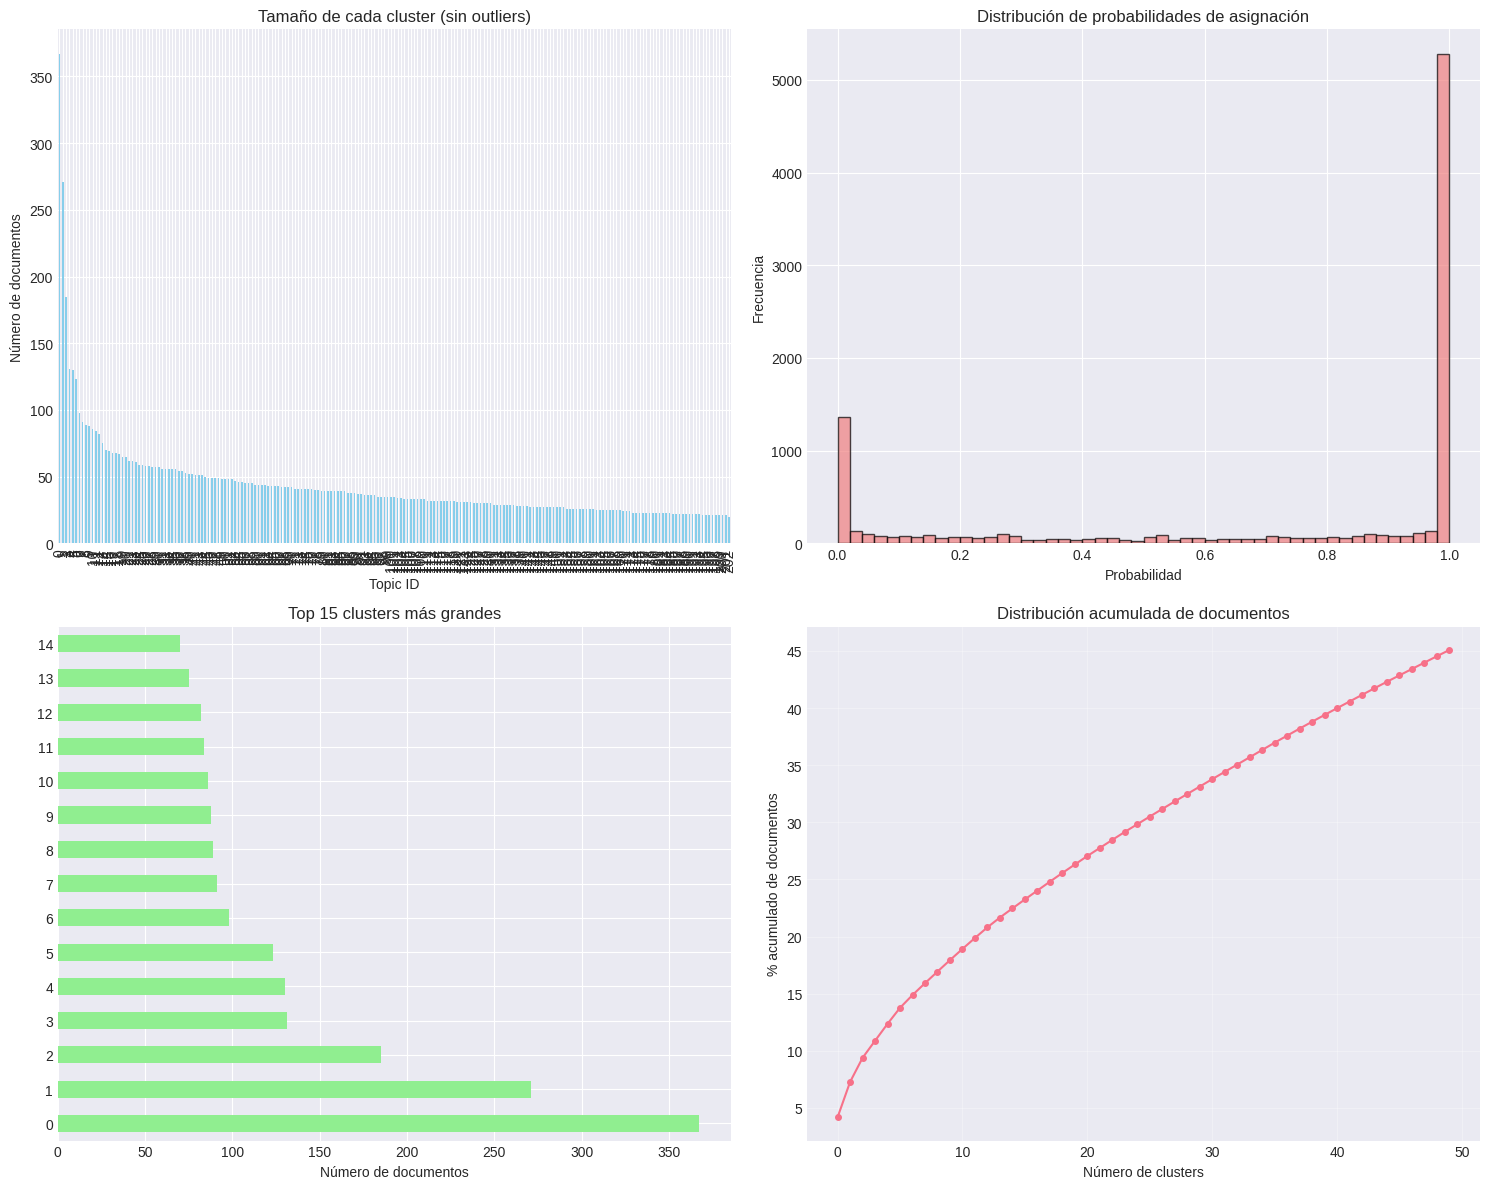

In [ ]:
# === VISUALIZAR DISTRIBUCIÓN DE CLUSTERS ===
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribución de tamaños
ax1 = axes[0, 0]
sizes_no_outliers = topic_sizes[topic_sizes.index != -1].sort_values(ascending=False)
sizes_no_outliers.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Tamaño de cada cluster (sin outliers)')
ax1.set_xlabel('Topic ID')
ax1.set_ylabel('Número de documentos')

# 2. Histograma de probabilidades
ax2 = axes[0, 1]
ax2.hist(probs, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
ax2.set_title('Distribución de probabilidades de asignación')
ax2.set_xlabel('Probabilidad')
ax2.set_ylabel('Frecuencia')

# 3. Top 15 clusters
ax3 = axes[1, 0]
top_15 = sizes_no_outliers.head(15)
top_15.plot(kind='barh', ax=ax3, color='lightgreen')
ax3.set_title('Top 15 clusters más grandes')
ax3.set_xlabel('Número de documentos')

# 4. Distribución acumulada
ax4 = axes[1, 1]
cumsum = sizes_no_outliers.cumsum() / sizes_no_outliers.sum() * 100
cumsum[:50].plot(ax=ax4, marker='o', markersize=4)
ax4.set_title('Distribución acumulada de documentos')
ax4.set_xlabel('Número de clusters')
ax4.set_ylabel('% acumulado de documentos')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# # 🔍 7. EXPLORACIÓN INTERACTIVA DE CLUSTERS


In [ ]:
# === FUNCIÓN PARA EXPLORAR UN CLUSTER ===
def explore_cluster(topic_id, n_samples=10):
    """Explora un cluster específico"""
    print(f"\n{'='*60}")
    print(f"🔍 EXPLORANDO CLUSTER {topic_id}")
    print(f"{'='*60}")

    # Info del tópico - Usar get_topic() que devuelve una lista de (palabra, score)
    topic_info = topic_model.get_topic(topic_id)
    topic_label = chatgpt_topic_labels.get(topic_id, "Sin etiqueta")

    print(f"\n📌 Etiqueta: {topic_label}")
    print(f"\n🔤 Top 15 palabras clave:")
    # Iterar directamente sobre la lista de tuplas
    for i, (word, score) in enumerate(topic_info[:15], 1):
        print(f"   {i:2d}. {word:<20} (score: {score:.4f})")

    # Documentos del cluster
    cluster_indices = [i for i, t in enumerate(topics) if t == topic_id]
    print(f"\n📊 Estadísticas:")
    print(f"   - Documentos en el cluster: {len(cluster_indices)}")
    print(f"   - Porcentaje del total: {len(cluster_indices)/len(topics)*100:.2f}%")

    # Probabilidades
    cluster_probs = [probs[i] for i in cluster_indices]
    print(f"   - Probabilidad promedio: {np.mean(cluster_probs):.3f}")
    print(f"   - Probabilidad mínima: {np.min(cluster_probs):.3f}")
    print(f"   - Probabilidad máxima: {np.max(cluster_probs):.3f}")

    # Muestras
    print(f"\n📝 Ejemplos de productos (mostrando {min(n_samples, len(cluster_indices))}):")
    sample_indices = np.random.choice(cluster_indices,
                                    size=min(n_samples, len(cluster_indices)),
                                    replace=False)

    for i, idx in enumerate(sample_indices, 1):
        print(f"\n   {i}. {abstracts[idx]}")
        print(f"      Prob: {probs[idx]:.3f} | Original: {df.iloc[idx]['descripcion_x'][:100]}...")


In [ ]:
# === BUSCAR CLUSTERS POR PALABRAS CLAVE ===
def find_clusters_by_keyword(keyword):
    """Encuentra clusters que contengan una palabra clave"""
    matching_clusters = []

    for topic_id in set(topics):
        if topic_id == -1:
            continue

        topic_words = [word for word, _ in topic_model.get_topic(topic_id)]
        if any(keyword.lower() in word.lower() for word in topic_words):
            size = sum(1 for t in topics if t == topic_id)
            matching_clusters.append((topic_id, chatgpt_topic_labels.get(topic_id, ""), size))

    if matching_clusters:
        print(f"\n🔎 Clusters que contienen '{keyword}':")
        for topic_id, label, size in sorted(matching_clusters, key=lambda x: x[2], reverse=True):
            print(f"   Topic {topic_id}: {label} ({size} docs)")
    else:
        print(f"\n❌ No se encontraron clusters con '{keyword}'")


In [ ]:
# Explorar cluster específico
explore_cluster(36)


🔍 EXPLORANDO CLUSTER 36

📌 Etiqueta: Productos de Ropa.

🔤 Top 15 palabras clave:
    1. aceite               (score: 0.2935)
    2. tshirt               (score: 0.1948)
    3. filtro               (score: 0.1352)
    4. tshirts              (score: 0.1017)
    5. manga                (score: 0.0136)
    6. camisa               (score: 0.0033)
    7.                      (score: 0.0000)
    8.                      (score: 0.0000)
    9.                      (score: 0.0000)
   10.                      (score: 0.0000)

📊 Estadísticas:
   - Documentos en el cluster: 54
   - Porcentaje del total: 0.55%
   - Probabilidad promedio: 0.534
   - Probabilidad mínima: 0.003
   - Probabilidad máxima: 1.000

📝 Ejemplos de productos (mostrando 10):

   1. blusa poliester
      Prob: 1.000 | Original: BLUSA 95% POLIESTER 5% SPANDEX/S,M,L/DAMA/AZUL/CHINA LC CU791-BLANCO...

   2. kit cobertor manufacturas de plastico
      Prob: 1.000 | Original: KIT COBERTOR PLASTICO TRANSPARENTE CIRCULAR PARA BASE 

In [ ]:
topic_model.get_topic_info(2)

,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,2,189,2_bolsos_mano_cartera_bolsa,Moda y Accesorios,"[bolsos, mano, cartera, bolsa, material, bolsa...",[Moda y Accesorios],"[bolsos mano, bolsos mano, bolsos mano]"


In [ ]:
# Buscar clusters relacionados con vehículos
find_clusters_by_keyword("filtro")
find_clusters_by_keyword("celular")
find_clusters_by_keyword("movil")


🔎 Clusters que contienen 'filtro':
   Topic 28: Productos industriales (57 docs)
   Topic 36: Productos de Ropa. (54 docs)
   Topic 58: Productos de mantenimiento para compresores. (45 docs)
   Topic 73: Categoría: "Productos de aire filtrado" (41 docs)
   Topic 165: Categoría: Productos de filtrado. (25 docs)

🔎 Clusters que contienen 'celular':
   Topic 1: Teléfonos móviles (271 docs)
   Topic 22: Electrónica Smartphones (62 docs)
   Topic 97: Categoría: Dispositivos inteligentes. (35 docs)
   Topic 145: Categoría: Teléfonos móviles Samsung (27 docs)
   Topic 182: Productos de tecnología (23 docs)
   Topic 185: Teléfonos móviles (22 docs)
   Topic 198: Electrónica de consumo (21 docs)

🔎 Clusters que contienen 'movil':
   Topic 0: Productos de transporte y repuestos (367 docs)
   Topic 21: Productos para vehículos de frenado. (62 docs)
   Topic 34: Accesorios de vehículos. (56 docs)
   Topic 47: Automotores (49 docs)
   Topic 59: Productos para vehículos y accesorios. (44 docs)
   T

# # 🎨 8. VISUALIZACIONES INTERACTIVAS


In [ ]:
# === VISUALIZACIÓN DE TÓPICOS ===
topic_model.visualize_topics(custom_labels=True)

In [ ]:
# === VISUALIZACIÓN DE BARCHART ===
# Ver palabras de clusters específicos
topic_model.visualize_barchart([2], custom_labels=True)

In [ ]:
# === MAPA DE DOCUMENTOS (muestra solo) ===
# Tomar una muestra para visualización
sample_size = 2000
sample_indices = np.random.choice(len(abstracts), size=sample_size, replace=False)

sample_embeddings = reduced_embeddings[sample_indices]
sample_topics = [topics[i] for i in sample_indices]
sample_abstracts = [abstracts[i] for i in sample_indices]

# Reducir a 2D para visualización
if sample_embeddings.shape[1] > 2:
    umap_2d = cuUMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    embeddings_2d = umap_2d.fit_transform(sample_embeddings)
else:
    embeddings_2d = sample_embeddings

# Visualizar
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=sample_topics, cmap='tab20', alpha=0.6, s=30)
plt.colorbar(scatter)
plt.title(f'Mapa de documentos (muestra de {sample_size})')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

IndexError: list index out of range

# # 💾 9. GENERAR CATEGORÍAS Y GUARDAR RESULTADOS

In [ ]:
# === FUNCIÓN PARA CREAR CATEGORÍAS CON GPT-4 ===
def create_categories_gpt4(topic_labels, n_categories=None):
    """Usa GPT-4 para agrupar subcategorías en categorías principales"""
    subcats = [f"{k}: {v}" for k, v in topic_labels.items() if k != -1]

    prompt = f"""
    Analiza la siguiente lista de subcategorías de productos. Agrúpalas en las categorías principales más naturales pero siempre deben existir las categorias Electrodomesticos, Cocina, Muebles y Decoracion, Automotriz, Ferreteria, Deportes, Papeleria, Jugetes y Juegos. estas son solo un baseline, lo demas hazlo a tu criterio,
    según el significado y similitud de sus nombres. El número de categorías lo decides tú, según lo que tenga más sentido.
    Incluye absolutamente todos los Topic que te paso, incluyendo -1.
    Devuelve SOLO un diccionario Python: Topic: (category_code, category_name)

    Subcategorías:
    {chr(10).join(subcats)}
    """

    if n_categories:
        prompt = prompt.replace("en categorías principales.",
                              f"en exactamente {n_categories} categorías principales.")

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.1,
        max_tokens=5000,
    )

    # Extraer diccionario
    content = response.choices[0].message.content
    code_match = re.search(r"```python\s*\n([\s\S]+?)```", content) or \
                re.search(r"(\{[\s\S]+\})", content)

    if code_match:
        return ast.literal_eval(code_match.group(1))
    else:
        raise ValueError("No se pudo extraer el diccionario")

# %%
# === GENERAR CATEGORÍAS Y ENRIQUECER DATAFRAME ===
print("🏷️ Generando categorías principales con GPT-4...")

# Crear mapping de categorías
topic_to_category = create_categories_gpt4(chatgpt_topic_labels, n_categories=None)

# Asegurar que todos los topics estén mapeados
for topic in set(topics):
    if topic not in topic_to_category:
        topic_to_category[topic] = (9999, "Sin Categoría" if topic != -1 else "Outlier Category")

# Agregar al dataframe
df["Topic"] = topics
df["subcategory"] = df["Topic"].map(chatgpt_topic_labels).fillna("Sin subcategoría")
df["category_code"] = df["Topic"].map(lambda x: topic_to_category.get(x, (9999, "Sin Categoría"))[0])
df["category"] = df["Topic"].map(lambda x: topic_to_category.get(x, (9999, "Sin Categoría"))[1])

print("✅ Categorías generadas exitosamente")


🏷️ Generando categorías principales con GPT-4...
✅ Categorías generadas exitosamente


In [ ]:
# === GUARDAR RESULTADOS ===
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f'tablas/bertopic_results_{timestamp}.csv'

df.to_csv(output_filename, index=False)
print(f"💾 Resultados guardados en: {output_filename}")

💾 Resultados guardados en: tablas/bertopic_results_20250805_181754.csv


In [ ]:
# Ver resumen
print("\n📊 RESUMEN FINAL:")
print(f"Total registros: {len(df):,}")
print(f"Subcategorías: {df['subcategory'].nunique()}")
print(f"Categorías principales: {df['category'].nunique()}")
print("\nTop 10 categorías:")
print(df['category'].value_counts().head(10))


📊 RESUMEN FINAL:
Total registros: 9,830
Subcategorías: 227
Categorías principales: 22

Top 10 categorías:
category
Ferretería                    1808
Electrodomésticos             1786
Moda                          1691
Automotriz                     962
Otros                          677
Decoración                     540
Belleza y Cuidado Personal     476
Textiles                       356
Empaque                        349
Juguetes y Juegos              308
Name: count, dtype: int64
